In [2]:
# import argparse
import numpy as np
import pandas as pd
from multiprocessing import cpu_count
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
#import keras

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

In [ ]:
!pip install wandb

In [3]:
import wandb

In [4]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
from wandb.keras import WandbCallback

In [6]:
wandb.init(project='w251-final-lstm-r18-224-f15-c5')

wandb: Currently logged in as: seancampos (use `wandb login --relogin` to force relogin)


In [32]:
# Initializing variables
window = 9 # depends on time window
epochs = 30
batch_size = 64
pose_vec_dim = 36 # depends on pose estimation model used
cores = cpu_count()

# class_names = ['ride_bike', 'run', 'sit', 'smile', 'smoke', 'stand', 'talk','walk']
class_names = ['drink_eat','sit_squat','phone_talk','walk','selfie']
num_class = len(class_names)
lbl_dict = {class_name:idx for idx, class_name in enumerate(class_names)}



In [36]:
input_file = 'preprocessoutput_ntu_r18_368.csv.gz'

In [37]:
dataset = pd.read_csv(input_file,  index_col=None)

In [38]:
labels = dataset['y'].unique()

In [39]:
test_dfs = []
for label in labels:
    a_label = dataset[dataset['y'] == label]
    test_set = a_label.sample(frac=0.20, random_state=0)
    test_dfs.append(test_set)
    dataset.drop(test_set.index,inplace=True)

290312
232249


In [42]:
pd.concat(test_dfs,ignore_index=True).to_csv('test_set_ntu_r18_368.csv', index=False)
dataset.to_csv('train_set_ntu_r18_368.csv', index=False)

In [40]:
X_train, X_test, y_train, y_test = load_data(dataset)

In [16]:
def load_data(dataset):
    
    y = dataset.pop('y')
    X = dataset.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    y_train = tf.keras.utils.to_categorical(list(map(lbl_dict.get, y_train)), num_class)
    y_test = tf.keras.utils.to_categorical(list(map(lbl_dict.get, y_test)), num_class)

    X_test = X_test.reshape(X_test.shape[0], pose_vec_dim, window)
    X_train = X_train.reshape(X_train.shape[0], pose_vec_dim, window)
    return X_train, X_test, y_train, y_test


In [17]:
def lstm_model():
    model = Sequential()
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_shape=(pose_vec_dim, window)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(class_names), activation='softmax'))
    print(model.summary())
    return model


In [18]:
out_file = 'lstm_ntu_r18_368.h5'


model = lstm_model()
    # model = tf.keras.models.load_model('./models/lstm.h5')
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

X_train, X_test, y_train, y_test = load_data(dataset)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               73728     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 98,821
Trainable params: 98,821
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks=[WandbCallback()])

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


model.save(out_file)
print("Saved model to disk")

Epoch 1/30
2608/2608 [==============================] - 264s 99ms/step - loss: 1.0821 - accuracy: 0.5349 - val_loss: 0.8844 - val_accuracy: 0.6191
Epoch 2/30
2608/2608 [==============================] - 251s 96ms/step - loss: 0.9061 - accuracy: 0.6153 - val_loss: 0.8165 - val_accuracy: 0.6523
Epoch 3/30
2608/2608 [==============================] - 255s 98ms/step - loss: 0.8451 - accuracy: 0.6424 - val_loss: 0.7540 - val_accuracy: 0.6795
Epoch 4/30
2608/2608 [==============================] - 250s 96ms/step - loss: 0.8033 - accuracy: 0.6632 - val_loss: 0.7202 - val_accuracy: 0.6996
Epoch 5/30
2608/2608 [==============================] - 254s 97ms/step - loss: 0.7678 - accuracy: 0.6791 - val_loss: 0.6730 - val_accuracy: 0.7210
Epoch 6/30
2608/2608 [==============================] - 252s 97ms/step - loss: 0.7415 - accuracy: 0.6950 - val_loss: 0.6677 - val_accuracy: 0.7351
Epoch 7/30
2608/2608 [==============================] - 257s 98ms/step - loss: 0.7188 - accuracy: 0.7042 - val_loss: 0

In [21]:
Y_pred = model(X_test)

In [22]:
Y_pred_labels = [class_names[np.argmax(y)] for y in Y_pred]

In [23]:
Y_true_labels = [class_names[np.argmax(y)] for y in y_test]

In [24]:
cm = confusion_matrix(Y_true_labels, Y_pred_labels, labels=class_names)

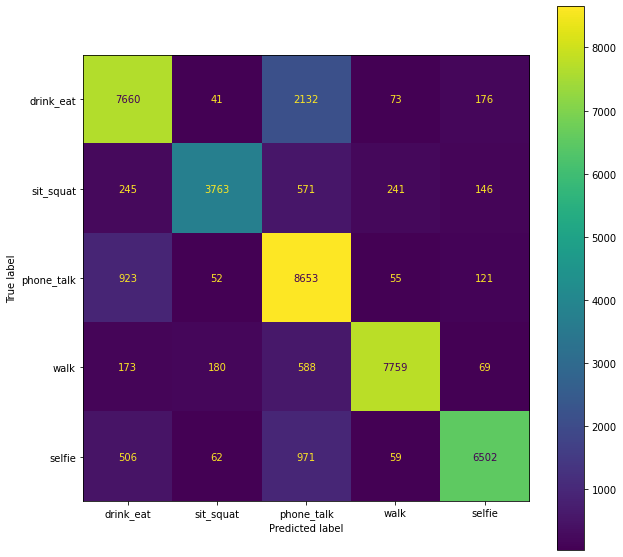

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(values_format=".5g", ax=ax)

In [26]:
wandb.finish()

epoch,29
loss,0.57251
accuracy,0.7779
val_loss,0.46064
val_accuracy,0.82301
_runtime,8079
_timestamp,1628098824
_step,29
best_val_loss,0.44343
best_epoch,26


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
val_loss,█▇▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▃▂▂▁▁▂▂▁▁▁▁▁▁
val_accuracy,▁▂▃▄▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇██▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


In [52]:
test_model = tf.keras.models.load_model('lstm_ntu_r18_368.h5', compile = False)

In [44]:
held_out_test = pd.read_csv('test_set_ntu_r18_368.csv')

In [46]:
y_ho = held_out_test.pop('y')
X_ho = held_out_test.values

In [47]:
y_ho_test = tf.keras.utils.to_categorical(list(map(lbl_dict.get, y_ho)), num_class)

In [48]:
x_ho_test = X_ho.reshape(X_ho.shape[0], pose_vec_dim, window)

In [53]:
Y_test_pred = test_model(x_ho_test)

In [54]:
Y_test_pred_labels = [class_names[np.argmax(y)] for y in Y_test_pred]

In [63]:
Y_test_true_labels = [class_names[np.argmax(y)] for y in y_ho_test]

In [64]:
cm = confusion_matrix(Y_test_true_labels, Y_test_pred_labels, labels=class_names)

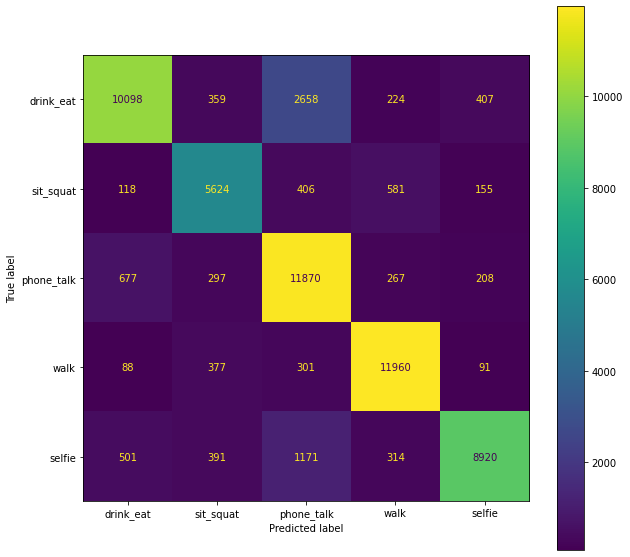

In [65]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(values_format=".5g", ax=ax)

In [67]:
print(classification_report(Y_test_true_labels, Y_test_pred_labels))

              precision    recall  f1-score   support

   drink_eat       0.88      0.73      0.80     13746
  phone_talk       0.72      0.89      0.80     13319
      selfie       0.91      0.79      0.85     11297
   sit_squat       0.80      0.82      0.81      6884
        walk       0.90      0.93      0.91     12817

    accuracy                           0.83     58063
   macro avg       0.84      0.83      0.83     58063
weighted avg       0.84      0.83      0.83     58063



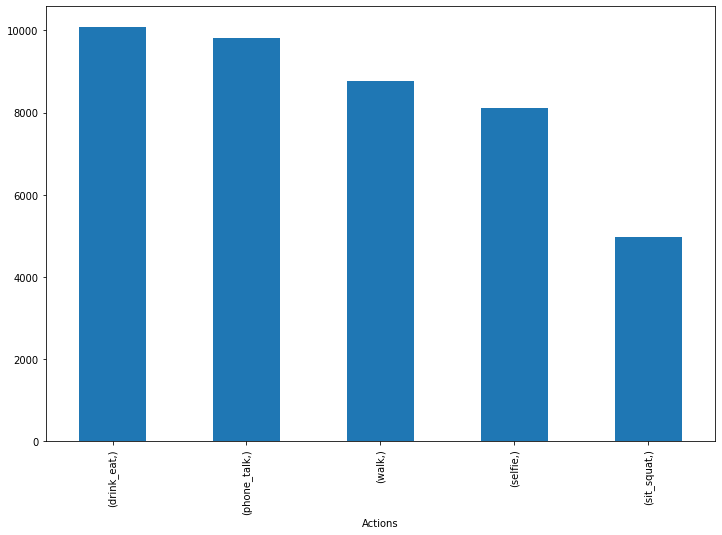

In [79]:
pd.DataFrame(Y_true_labels,columns=['Actions']).value_counts().to_frame().plot.bar(figsize=(12,8),legend=None)